# Assignment 2

In [1]:
from collections import defaultdict, Counter
import re
import gzip
import json
import pickle
import numpy as np
import pandas as pd
import string
import gensim
import sklearn
from tqdm import tqdm

## Meta cleaning

In [ ]:
# Read meta data as DataFrame
with gzip.open('meta_CDs_and_Vinyl.json.gz','r') as f:
    meta = pd.DataFrame.from_records(json.loads(line) for line in f)
    print(f'# of items: {len(meta)}')

In [ ]:
# Drop duplicate items
mask = meta['asin'].duplicated()
print(f'# of duplicate items: {mask.sum()}')
meta.drop_duplicates('asin',inplace=True)
print(f'Remaining: {len(meta)}')
# Drop unwanted columns
unwanted = [
    'tech1', 'fit', 'tech2', 'brand', 'feature', 'main_cat',
    'similar_item', 'date', 'price', 'imageURL', 'imageURLHighRes'
]  # description, brand
meta.drop(columns=unwanted,inplace=True)
# meta_df['details'].fillna(r'{}',inplace=True)

In [ ]:
# Drop unwanted categories
meta.loc[:,'category'] = meta['category'].apply(lambda l: l[1])
unwanted = set(
    ('Christian', 'Soundtracks', 'Broadway & Vocalists', 'Holiday & Wedding',
     'Comedy & Spoken Word', 'Karaoke', 'Special Interest', 'Gospel'))
mask = meta['category'].apply(unwanted.__contains__)
meta.drop(meta.index[mask],inplace=True)
print(f'''# of items of unwanted categories: {mask.sum()}
Remaining: {len(meta)}''')

In [ ]:
cate_count = Counter(meta['category'])
cate_count = dict(cate_count.most_common())
cate_index = dict(zip(cate_count.keys(),range(len(cate_count))))
cate_count = np.fromiter(cate_count.values(),'int',len(cate_count))
item_cate = dict(zip(meta['asin'],meta['category'].apply(cate_index.get)))
%store cate_count cate_index item_cate

In [ ]:
# Change the ranks in list to single rank
mask = meta['rank'].apply(lambda l: type(l) is list)
meta.loc[mask,'rank'] = meta.loc[mask,'rank'].apply(
    lambda l: next((x for x in l if 'in CDs & Vinyl' in x),'')
)
print(f'# of items whose rank is a list: {mask.sum()}')

In [ ]:
# Drop items with no rank in CDs & Vinyl
mask = ~meta['rank'].str.contains(' in CDs & Vinyl')
meta.drop(meta.index[mask],inplace=True)
print(f'''# of items without ranking: {mask.sum()}
Remaining: {len(meta)}''')
# Convert rank to int
meta['rank'] = meta['rank'].apply(
    lambda s: int(re.search(r'(\d+(,\d+)*)',s).group().replace(',',''))
)

In [ ]:
mask = (meta['also_view'].apply(lambda l: bool(len(l)))
        | meta['also_buy'].apply(lambda l: bool(len(l))))
n_sample = 250000
drop_idx = meta.loc[~mask].sample(len(meta)-n_sample,random_state=42).index
meta.drop(drop_idx,inplace=True)

In [ ]:
# meta.reset_index(drop=True,inplace=True)
# meta.to_feather('meta.ftr',compression='lz4')
meta = pd.read_feather('meta.ftr')

In [ ]:
items = set(meta['asin'])
# with open('items.pkl', 'wb') as file:
#     pickle.dump(items, file)
# with open('items.pkl', 'rb') as file:
#     items = pickle.load(file)

## Reviews cleaning

In [ ]:
from gensim.utils import tokenize, simple_preprocess

def process(file):
    for line in file:
        review = json.loads(line)
        if review['asin'] in items and 'reviewText' in review:
            tokens = simple_preprocess(review['reviewText'],deacc=True)
            if len(tokens) > 1:
                review['reviewText'] = ' '.join(tokens)
                yield review

In [ ]:
# Read reviews data as DataFrame, ignoring the ones without review text

with gzip.open('CDs_and_Vinyl.json.gz','r') as f:
    reviews = pd.DataFrame.from_records(process(f))
    print(f'# of reviews: {len(reviews)}')

In [ ]:
# Drop unwanted columns
unwanted = ['verified','summary','style','image','reviewTime']
reviews.drop(columns=unwanted,inplace=True)
reviews['vote'].fillna('0',inplace=True)
reviews['vote'] = reviews['vote'].str.replace(',','').astype(int)
reviews['overall'] = reviews['overall'].astype(int)

In [ ]:
reviews.to_feather('reviews.ftr',compression='lz4')
# reviews = pd.read_feather('reviews.ftr')

## Baseline

In [ ]:
meta = pd.read_feather('meta.ftr')

In [2]:
%store -r cate_count cate_index item_cate

In [ ]:
also_buy_cate = meta['also_buy'].apply(
    lambda l: [x for x in map(item_cate.get, l) if x != None])
also_view_cate = meta['also_view'].apply(
    lambda l: [x for x in map(item_cate.get, l) if x != None])

In [ ]:
def feature19(row):
    arr = np.zeros(len(cate_count),'int')
    if c := Counter(cate for l in row for cate in l):
        idx,count =  zip(*c.items())
        arr[list(idx)] = count
    return arr

def feature38(row):
    also_buy,also_view = row
    arr1 = np.zeros(len(cate_count),'int')
    arr2 = np.zeros(len(cate_count),'int')
    if c := Counter(also_buy):
        idx,count =  zip(*c.items())
        arr1[list(idx)] = count
    if c := Counter(also_view):
        idx,count =  zip(*c.items())
        arr2[list(idx)] = count
    return np.r_[arr1,arr2]

test = pd.DataFrame({'buy': also_buy_cate, 'view': also_view_cate})
X19 = test.apply(feature19, axis=1,result_type='expand').to_numpy()
X38 = test.apply(feature38, axis=1,result_type='expand').to_numpy()
y = y.to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
X19_train,X19_test,y_train,y_test = train_test_split(X19,y,test_size=0.25,random_state=42)
X38_train,X38_test,y_train,y_test = train_test_split(X19,y,test_size=0.25,random_state=42)

## doc2vec

In [3]:
reviews = pd.read_feather('reviews.ftr')

In [4]:
reviews_grouped = reviews.groupby('asin',group_keys=True)['reviewText'].apply(
    lambda ser: ' '.join(ser)
)
reviews_grouped = pd.DataFrame(reviews_grouped)
reviews_grouped.reset_index(inplace=True)

248349 items with review

In [10]:
c = Counter(w for review in reviews_grouped['reviewText'] for w in tokenize(review))

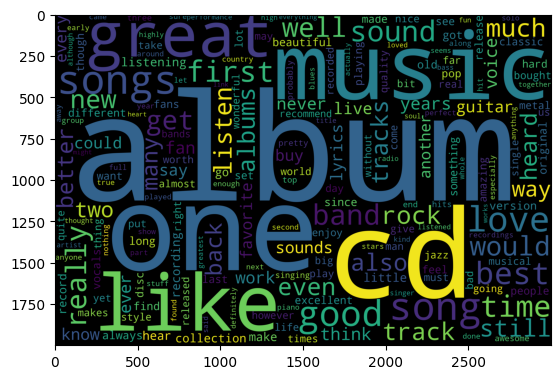

In [37]:
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
stop_words = set(nltk.corpus.stopwords.words('english'))
wc = WordCloud(width=3000,height=2000).generate_from_frequencies(c)
wc.to_file('wordcloud.png')
plt.imshow(wc)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english',use_idf=True,min_df=10)

In [43]:
X = vectorizer.fit_transform(reviews_grouped['reviewText'])
y = reviews_grouped['asin'].apply(item_cate.__getitem__)

In [44]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [45]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(19,19)).fit(X_train,y_train)
clf.score(X_train,y_train), clf.score(X_test,y_test)

c:\Users\shz42\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


(0.9796556254058053, 0.48707469297362593)

In [ ]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred,target_names=cate_index.keys()))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.show()

In [ ]:
from gensim.utils import tokenize
from gensim.models.doc2vec import TaggedDocument
def tagged(df):
    return df.apply(
        lambda r: TaggedDocument(list(tokenize(r['reviewText'])),[item_cate[r['asin']]]),
        axis=1)
train_tagged = tagged(train)
test_tagged = tagged(test)

In [ ]:
w2v = gensim.models.Doc2Vec(vector_size=100,min_count=100)
w2v.build_vocab(x for x in tqdm(train_tagged))

In [ ]:
w2v.train(train_tagged.values,total_examples=len(train_tagged),epochs=5)

In [ ]:
w2v.infer_vector(train.loc[132703,'reviewText'])

In [ ]:
train.apply(lambda r: w2v.infer_vector(r['reviewText']))

In [ ]:
w2v.infer_vector(train_tagged[0].words)

In [ ]:
word_count = Counter(
    word for review in reviews['reviewText']
    for word in tokenize(review)
)
# with open('word_count.plk','wb') as f:
#     pickle.dump(word_count,f)
# with open('word_count.plk','rb') as f:
#     word_count = pickle.load(f)